# Topic clustering

Topic clustering is unsupervised task since we use unlabeled data. The aim of topic clustering is to categorize corpus of text into homogenized clusters (just like what we have in clustering tasks).

In this project, I use a sample of 2000 news texts as the data source. Then, I apply various text cleaning and preprocessing techniques to make the corpus ready for various clustering methods. Afterwards, I use kmeans and LDA to cluster the text and compare the results.

In [133]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# NLP
import nltk
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
import gensim
import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim.models import TfidfModel, LdaModel,LdaMulticore, CoherenceModel
import spacy
from gensim.utils import simple_preprocess
from collections import Counter

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
# reading the data
df = pd.read_csv("https://github.com/sajadahmadia/NLP/raw/main/topic_clustering/raw_data.csv")
print(df.shape)
df.head()

(2000, 9)


,Unnamed: 0,outlet,title,keywords,description,datetime,authors,category,body
0,7780,Wired,How to Watch Movies in Virtual Reality,"['meta', 'netflix', 'amazon prime', 'oculus', ...",Setting up a VR cinema is simple and proves yo...,2022-01-09 07:00:00,['Reece Rogers'],Gear,With bots and console resellers snatching away...
1,15708,Guardian,Can we create a moral metaverse?,"['The metaverse', 'Virtual reality', 'Online a...","In the increasingly lifelike worlds of VR, hig...",2022-05-14 14:00:04,['Laurie Clarke'],Technology,Psychotherapist Nina Jane Patel had been on F...
2,11975,NYT,"92nd Street Y to Host Ron Howard, Gwyneth Palt...","['Books', 'Ninety-Second Street Y', 'Gwyneth P...",The 2019-20 season also features appearances b...,2019-07-17 17:00:04,Sara Aridi,Arts,The upcoming season at 92nd Street Y will feat...
3,12986,NYT,Steven Spielberg on Storytelling’s Power to Fi...,"['Steven Spielberg', 'Shoah Foundation', 'War ...","The director is reissuing “Schindler’s List,” ...",2018-12-18 20:19:54,Adam Popescu,Arts,"LOS ANGELES — “Pinchas, how old are you?” Stev..."
4,5671,Wired,Mass Transit Is in Jeopardy—and So Are Cities,"['public transportation', 'mass transit', 'cit...",Subways and buses are the lifeblood of dense c...,2020-12-14 07:00:00,['Aarian Marshall'],Business,"In the New York City of February 2020, a misse..."


As it appears, our dataset consists of  news articles from NYT(New York Times), Wired, and .... (different news agencies) including their keywords, categories, full text body, time of pulication, and ... . There is also an additional column (Unnamed: 0) that should be removed.

In [14]:
# dropping the Unnamed: 0 column
df.drop(columns = {"Unnamed: 0"}, inplace = True)
df.columns

Index(['outlet', 'title', 'keywords', 'description', 'datetime', 'authors',
       'category', 'body'],
      dtype='object')

## Text preprocessing

At this step, I use different preprocessing techniques to prepare the corpus for using in topic clustering algorithms. I use the body column of the dataframe since it contains the largest amount of data in comparison to other columns, but using other columns or using multiple of them is also recommened for future studies.

In [16]:
# loading the English language model provided by spaCy
nlp = spacy.load("en_core_web_sm")

**Text tokenization:**

using the above nlp function, I transform the text in the body column into a list of separated words. The nlp function not only tokenizes the words but also do a whole nlp process on them, ie, it retrieves some meta data for each word like Part of Speech tag for each word.

In [18]:
df['text_nlp'] = df['body'].apply(lambda x: nlp(str(x)))

In [20]:
df[['body','text_nlp']].head()

,body,text_nlp
0,With bots and console resellers snatching away...,"(With, bots, and, console, resellers, snatchin..."
1,Psychotherapist Nina Jane Patel had been on F...,"( , Psychotherapist, Nina, Jane, Patel, had, b..."
2,The upcoming season at 92nd Street Y will feat...,"(The, upcoming, season, at, 92nd, Street, Y, w..."
3,"LOS ANGELES — “Pinchas, how old are you?” Stev...","(LOS, ANGELES, —, “, Pinchas, ,, how, old, are..."
4,"In the New York City of February 2020, a misse...","(In, the, New, York, City, of, February, 2020,..."


As we can see, the text_nlp column now contains the tokenized version fo the body column. It also includes some other meta data like the part of speech tag of the word(ie, whether the word is a noun, verb, adverb, ....). You can see the universal part of speech tags [here](https://universaldependencies.org/u/pos/) . To show the meaning of Part of Speech(POS), I apply it on the first row of the body column


In [24]:
first_row = nlp(df.iloc[0,-2])

spacy.displacy.render(first_row, style='ent', jupyter=True)

In the next step, I choose only some part of speech tags that are more meaningful(in my opinion) for clustering texts.

In [67]:
def include_features(x):
    include_features = ['VERB', 'PROPN', 'NOUN', 'ADJ', 'PRON']
    text = ' '.join([ent.text for ent in x if ent.pos_ in include_features])
    return text

df['features'] = df['text_nlp'].apply(lambda x: include_features(x))

In [68]:
df['features']

0       bots console resellers snatching many people c...
1       Psychotherapist Nina Jane Patel Facebook Horiz...
2       upcoming season 92nd Street Y feature a who ’s...
3       LOS ANGELES Pinchas old you Steven Spielberg a...
4       New York City February missed subway train nui...
                              ...                        
1995    Monitor weekly column devoted everything happe...
1996    welcome edition Monitor WIRED entertainment ne...
1997    driverless cars delivery drones new generation...
1998    WASHINGTON Executives Facebook Twitter Google ...
1999    DALAD BANNER China They worked factory hands c...
Name: features, Length: 2000, dtype: object

As it looks, some words in each row is removed(those that were not part of the mentioned POS tags). As an example, I investigate the length of the first body before and after applying the POS tagging filter:


In [69]:
print(f"the length of the first body before filtering based on POS tags {len(df.iloc[0,-3])}\nafter filtering the tags {len(df.iloc[0,-1])}")

the length of the first body before filtering based on POS tags 5624
after filtering the tags 3810


### Removing stop words and retrieving the lemma form of words

* Stop words are set of commonly used words in a language. Examples of stop words in English are "a","an","the","your",... . We usually remove these words while doing nlp tasks to reach more important words

* lemma of a word is the root form of that word. for example, the lemma of "are", "is", and "was" is "be". In nlp, we usually use the lemmatized form a word to ignore the grammatical differences of the same root word.

In the next step, I create a function to first remove punctuation and lowercase words while returning a tokenized version of each text, then remove stop words and finally gets the lemmatized form of each word.

In [70]:
# retreiving the English stop words and adding "and" as an additional word to it
stop_words = stopwords.words('english')
stop_words.extend(["and"])

# using nltk library to get the lemmatized version of words
lemmatizer = nltk.stem.WordNetLemmatizer()

def clean_text(text):
    tokens = simple_preprocess(text)
    # remove stopwords
    text = [token for token in tokens if not token in stop_words]
    # lemmatization
    text = [lemmatizer.lemmatize(word) for word in text]
    return text

In [136]:
df['features']

0       [bot, console, resellers, snatching, many, peo...
1       [psychotherapist, nina, jane, patel, facebook,...
2       [upcoming, season, nd, street, feature, celebr...
3       [los, angeles, pinchas, old, steven, spielberg...
4       [new, york, city, february, missed, subway, tr...
                              ...                        
1995    [monitor, weekly, column, devoted, everything,...
1996    [welcome, edition, monitor, wired, entertainme...
1997    [driverless, car, delivery, drone, new, genera...
1998    [washington, executive, facebook, twitter, goo...
1999    [dalad, banner, china, worked, factory, hand, ...
Name: features, Length: 2000, dtype: object

In [72]:
df['features'] = df['features'].apply(lambda text: clean_text(text))
df['features']

0       [bot, console, resellers, snatching, many, peo...
1       [psychotherapist, nina, jane, patel, facebook,...
2       [upcoming, season, nd, street, feature, celebr...
3       [los, angeles, pinchas, old, steven, spielberg...
4       [new, york, city, february, missed, subway, tr...
                              ...                        
1995    [monitor, weekly, column, devoted, everything,...
1996    [welcome, edition, monitor, wired, entertainme...
1997    [driverless, car, delivery, drone, new, genera...
1998    [washington, executive, facebook, twitter, goo...
1999    [dalad, banner, china, worked, factory, hand, ...
Name: features, Length: 2000, dtype: object

As an example, the first three words of the first body (without applying any preprocessing) is "bots console resellers snatching", while after applying the whole preprocessing process it became "bot console resellers snatching". The lemmatizer function removed the plural "s" from the "bots" word.

### TF-IDF(Term Frequency-Inverse Document Frequency)
TF-IDF shows the importance of a word in a document amoung a collection of documents (here, body column).
TF is calculated as:

* **TF(t,d)**= Total number of terms in document d / Number of times term t appears in document d

and IDF is calculated as:

* **IDF(t,D)**=log(
Number of documents containing term (t+1)/
Total number of documents in the corpus N
​
 )

corpus is the collection of all texts, here the body column.

Finally, TF-IDF is the multiplication of these two scores, which shows the importance of a word(and not only the frequency of a word).

To get the TF-IDF score, first, I need to create a Gensim Dictionary from the preprocessed column.



In [73]:
# Create a Gensim Dictionary from the documents
gensim_dict = Dictionary(df['features'])

# Convert the documents to a bag-of-words format using the dictionary
corpus = [gensim_dict.doc2bow(doc) for doc in df['features']]

# Convert the TF-IDF matrix to Gensim's sparse format
tfidf = TfidfModel(corpus, dictionary=gensim_dict)
corpus = tfidf[corpus]

To get an understanding of what happened after applying the tf-idf model, I just print the first values of the first 5 documents.Showing all the tf-idf values even for the first document(which has 3810 words) might not be useful:

In [82]:
# display the words and their TF-IDF values:
for i, doc_tfidf in zip(range(2),corpus):
    print(f"\nDocument {i + 1} TF-IDF values:")
    for word_id, tfidf_value in doc_tfidf[:10]:
        word = gensim_dict[word_id]
        print(f"{word}: {tfidf_value:.4f}")


Document 1 TF-IDF values:
access: 0.0170
accessed: 0.0290
account: 0.0111
action: 0.0107
active: 0.0350
additional: 0.0159
alien: 0.0215
allow: 0.0115
amazon: 0.0109
app: 0.1317

Document 2 TF-IDF values:
account: 0.0096
action: 0.0093
allow: 0.0100
avatar: 0.1186
body: 0.0207
data: 0.0049
entertainment: 0.0151
environment: 0.0428
experience: 0.0317
experienced: 0.0309


## Topic Clustering
Finally, we come to the interesting part: topic clustering! I use LDA algorithm (Latent Dirichlet Allocation) to find tipic clusters. LDA uses Dirichlet distributions to model the mixture of topics in documents and the distribution of words in topics. Dirichlet distributions are a family of continuous probability distributions often used to model the distribution of probabilities over a fixed set of possible outcomes. For a detailed explanation, see this [link](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation). But before getting into the interesting part, we should come up with an idea to address a frequently asked topic:

### A highly-frequent topic: Determining the number of clusters

Since clustering is an unsupervised technique, determining the number of clusters(especially in those algorithms that we can pre-determine the number of clusters) is an arbitrary choice that might affect our results hugely. As a result, I try different number of clusters and use a coherence metric to calculate topic coherence for each model.

In [75]:
# Train the Gensim LDA model
num_topics = 5
gensim_lda = LdaModel(corpus, num_topics=num_topics, id2word=gensim_dict)

In [86]:
topics = []
score = []
models = []
for i in range(2,21,2):
   lda_model = LdaMulticore(corpus=corpus, id2word=gensim_dict, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
   cm = CoherenceModel(model=lda_model, texts = df['features'], corpus=corpus, dictionary=gensim_dict, coherence='c_v')
   topics.append(i)
   models.append(lda_model)
   score.append(cm.get_coherence())

Although I used the faster version of lda model function(LdaMulticore), it took almost 30 minutes to run. Since I used c_v as the coherene parameter, it returns a value between 0 and 1, the nearer to 1 the better. In the next step, I use the elbow rule to find the best number of clusters that stands out for the number of clusters(model complexity)-performance tradeoff.

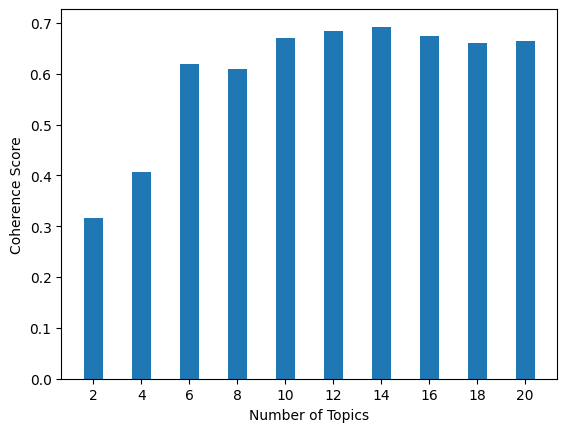

In [101]:
#plotting the c_v value per number of clusters
plt.bar(topics, score)
plt.xticks(topics, np.arange(2,21,2))
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.show()

As it seems, using 10 clusters might be good enough.

In [111]:
selected_model = models[4]

# Get a single topic as a formatted string, a combination of coefficients * words per topic cluster
selected_model.print_topics()

[(0,
  '0.000*"roux" + 0.000*"tasty" + 0.000*"pozo" + 0.000*"massimino" + 0.000*"dma" + 0.000*"mobilecoin" + 0.000*"brewer" + 0.000*"gannett" + 0.000*"imessage" + 0.000*"sediment"'),
 (1,
  '0.001*"ai" + 0.001*"mr" + 0.001*"facebook" + 0.001*"google" + 0.001*"game" + 0.001*"company" + 0.001*"said" + 0.001*"robot" + 0.001*"data" + 0.001*"human"'),
 (2,
  '0.000*"yandex" + 0.000*"tiger" + 0.000*"gpt" + 0.000*"vet" + 0.000*"hikvision" + 0.000*"lamda" + 0.000*"westworld" + 0.000*"jade" + 0.000*"coffman" + 0.000*"zauner"'),
 (3,
  '0.000*"def" + 0.000*"knot" + 0.000*"ramey" + 0.000*"shadowserver" + 0.000*"hoa" + 0.000*"spitzer" + 0.000*"toutiao" + 0.000*"kettering" + 0.000*"karray" + 0.000*"hcl"'),
 (4,
  '0.002*"content" + 0.002*"found" + 0.000*"solms" + 0.000*"jellyfish" + 0.000*"clipchamp" + 0.000*"scif" + 0.000*"digitalglobe" + 0.000*"tahhan" + 0.000*"juggling" + 0.000*"halla"'),
 (5,
  '0.007*"nan" + 0.001*"tournament" + 0.000*"gebru" + 0.000*"clearview" + 0.000*"federer" + 0.000*"seed

finding topics in LDA is not as easy as what we see in KMeans or other clustering algorithms. LDA assigns a probability score for each document to be assigned to each topic cluser. For simplicity, I show the first 5 documents an their assigned cluster probabilities. For more information, use the gensim documentation [here](https://radimrehurek.com/gensim/models/ldamulticore.html#module-gensim.models.ldamulticore)

In [112]:
# Get the topic distribution for each document
topic_documents = selected_model.get_document_topics(corpus)
[doc for doc in topic_documents[:5]]

[[(0, 0.011786871),
  (1, 0.89379317),
  (2, 0.01178686),
  (3, 0.0117868595),
  (4, 0.01178686),
  (5, 0.011786866),
  (6, 0.01178686),
  (7, 0.011911935),
  (8, 0.0117868595),
  (9, 0.011786868)],
 [(1, 0.9314607)],
 [(0, 0.013924522),
  (1, 0.8746297),
  (2, 0.013924522),
  (3, 0.013972309),
  (4, 0.01392459),
  (5, 0.013924521),
  (6, 0.013924711),
  (7, 0.013924528),
  (8, 0.013924518),
  (9, 0.013926154)],
 [(1, 0.9318203)],
 [(1, 0.9124805)]]

gensim has a helper function for converting to and from numpy/scipy arrays. I convert the topics into a numpy array and then a dataframe to show them:

In [122]:
all_topics_csr = gensim.matutils.corpus2csc(topic_documents)
all_topics_numpy = all_topics_csr.T.toarray()
topic_probability = pd.DataFrame(all_topics_numpy)
topic_probability.head()

,0,1,2,3,4,5,6,7,8,9
0,0.011786,0.893718,0.011786,0.011786,0.011786,0.011786,0.011786,0.011994,0.011786,0.011786
1,0.000000,0.931461,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.013925,0.874629,0.013925,0.013973,0.013925,0.013925,0.013925,0.013925,0.013925,0.013926
3,0.000000,0.931820,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.912480,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


for the first document, the second cluster(cluster at inex = 1) has the highest probability(about 0.89). for the second document, again the second cluster has the highest probability. and ... . I get the max of each row and assign it as our cluster number. I also add a +1 to cluster numbers to make it more human friendly.

In [128]:
# finding the max. value per row, retrieving its column name, adding +1 to it
clusters = topic_probability.idxmax(axis="columns")+1
# assigning the clusters to a new column
df['clusters'] = clusters
df['clusters'].head()

0    2
1    2
2    2
3    2
4    2
Name: clusters, dtype: int64

In [131]:
# checking the number of observations per cluster
df['clusters'].value_counts()

2    1944
6      39
5      15
4       1
7       1
Name: clusters, dtype: int64

ooh, the second cluster encompasses almost more than 95% of all the observations! Let's see the highest frequency words for each topic. To do so, I should first group all 'features' per cluster to make a single list for each cluster. then, use the counter function of the collection library to easily count the number of words per cluster:

In [135]:
# stack list of words together
cluster_words = df.groupby('clusters')['features'].sum()

# count the frequency of each word in each cluster
cluster_word_counts = cluster_words.apply(Counter)

# get the top 10 words per cluster
top_words_per_cluster = cluster_word_counts.apply(lambda x: x.most_common(10))

# showing the result
for cluster, top_words in top_words_per_cluster.items():
    print(f"\nCluster {cluster} - Top {10} words:")
    for word, count in top_words:
        print(f"{word}: {count}")


Cluster 2 - Top 10 words:
say: 6749
said: 6534
company: 6369
new: 5955
year: 5939
people: 5924
time: 5563
make: 3979
way: 3893
work: 3687

Cluster 4 - Top 10 words:
def: 8
match: 7
mauresmo: 6
france: 6
russia: 5
slovakia: 4
cibulkova: 4
round: 4
italy: 4
seeded: 4

Cluster 5 - Top 10 words:
content: 14
found: 14
tai: 4
chi: 4
beijing: 3
brh: 3
institute: 2
technology: 2
robot: 2
bot: 2

Cluster 6 - Top 10 words:
nan: 39

Cluster 7 - Top 10 words:
sweater: 4
pant: 4
frye: 4
company: 4
boot: 4
coat: 4
dress: 3
worn: 3
hermès: 3
wrangler: 2


Based on my understanding, and if I want to name the clusters based on their top words, I come up with these names:
* cluster 2: people work in newyork time!
* cluster 4: countries
* cluster 6: nan, which is awkward and needs more investigation.
* cluster 7: clothes

**No need to mention**, I didn't try to to clean up the unexpected results that might happen when doing topic clustering, because it is the reality of our job. Each investigation provides some ideas for further and better models, and we come up with a newer model, and again and again ....

# Conclusion

Topic clustering is a widespread task in NLP. Although it seems at the first glance, It requires further investigations and human checks. In this project, I tried to be fair and didn't manipulated the data to get just nice results; Meanwhile, I wanted to show the reality of the first results that we might get when doing an unsupervised nlp task.

Totally, I found only foure meaningful clusters and then named the clusters to a more human-friendly names.